In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/UFRGS/CV/TF
%ls -lah

/content/drive/MyDrive/Colab Notebooks/UFRGS/CV/TF
total 16K
drwx------ 2 root root 4.0K Apr 14 19:11 checkpoints/
drwx------ 2 root root 4.0K Apr  5 11:56 data/
drwx------ 2 root root 4.0K Apr  6 22:25 notebooks/
drwx------ 2 root root 4.0K Apr 14 21:11 vgg/


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from vgg.vgg_unet_aspp_detection import UNetVgg
from vgg.utils import pt_utils, plot_utils
from vgg.dataset import BacteriaDataset
from vgg.utils.converters import Converters

In [6]:
converters = Converters()

In [7]:
def _init_loader_seed():
    np.random.seed(torch.initial_seed() % 2 ** 32)

In [8]:
TEST_DIR = "./data/test"
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
RESOLUTION = [IMAGE_HEIGHT, IMAGE_WIDTH]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_WORKERS = 2
NUM_EPOCHS = 1000
SEED = _init_loader_seed()
CLASS_WEIGHTS = [0.1, 0.55, 1]

In [9]:
test_ds = BacteriaDataset(base_path=TEST_DIR, is_train=False, resolution=RESOLUTION)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    worker_init_fn=SEED)

In [19]:
nClasses = len(CLASS_WEIGHTS)
model, _ = pt_utils.load_model_with_meta(UNetVgg, "./checkpoints/unet_vgg_v2.pth", nClasses)
model.to(DEVICE)
model.eval()

Model Info:
date: 2021-04-13 21:28:44.529919
additional_info: {'best_train_acc': 0.9800185416508647, 'best_train_loss': 0.05657276382239965, 'best_train_iou': 0.8228448683685748, 'best_val_acc': 0.9692214619029652, 'best_val_iou': 0.7382152457156308, 'best_epoch': 56, 'weights': [0.1, 0.55, 1], 'resolution': [256, 256], 'augmentation': False}


UNetVgg(
  (vgg0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (vgg1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (vgg2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (vgg3): Sequen

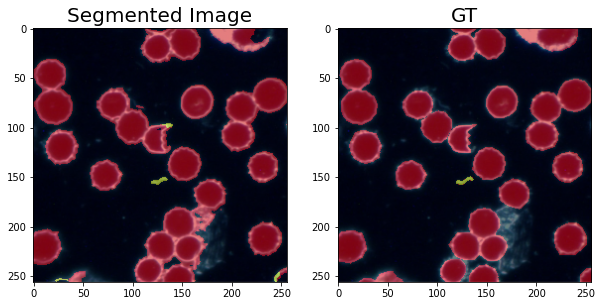

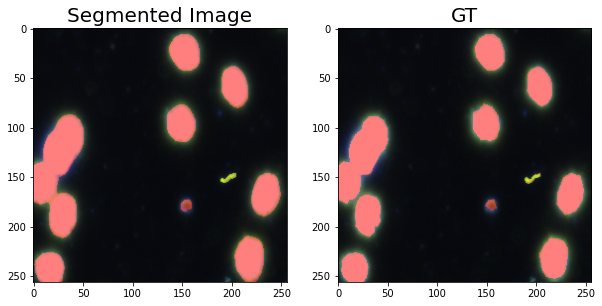

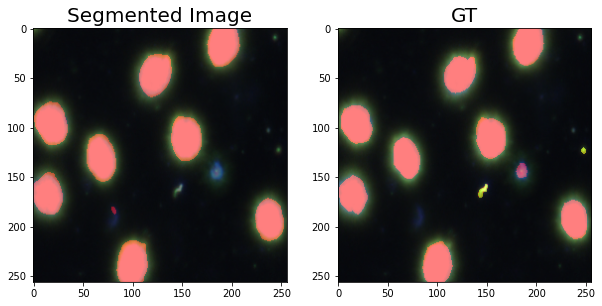

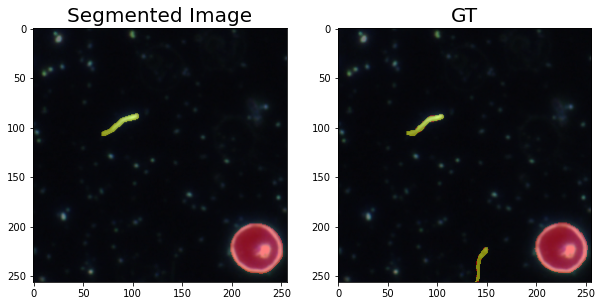

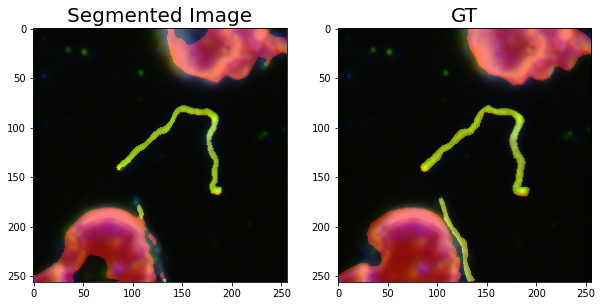

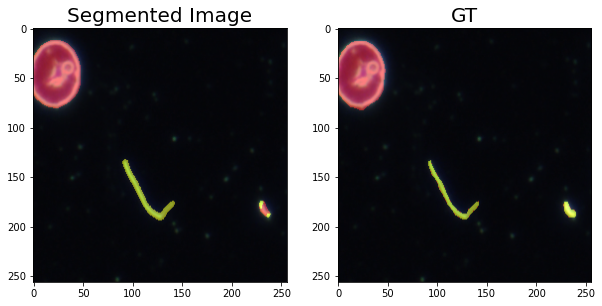

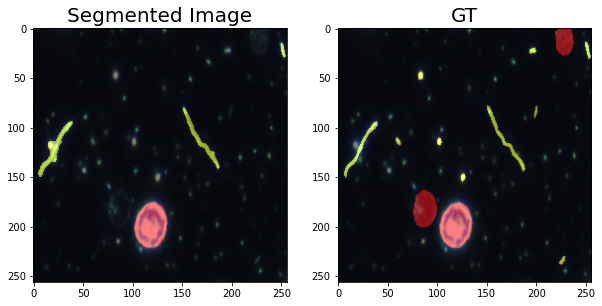

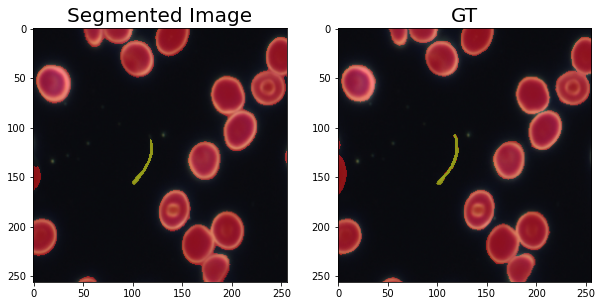

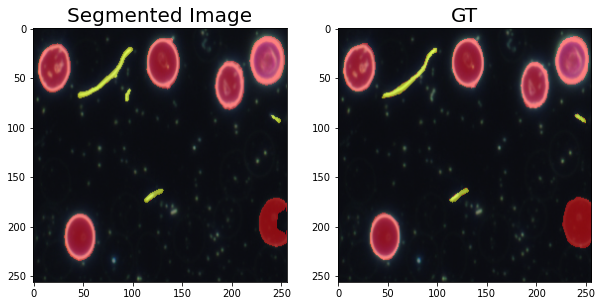

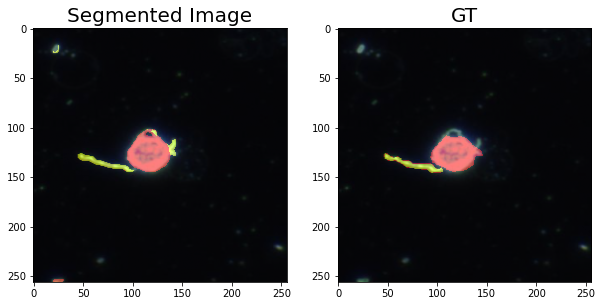

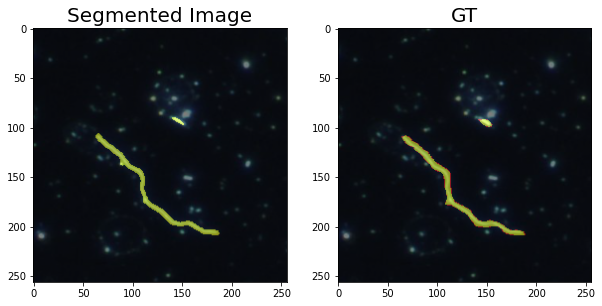

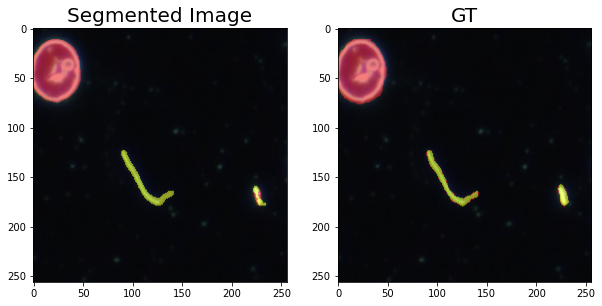

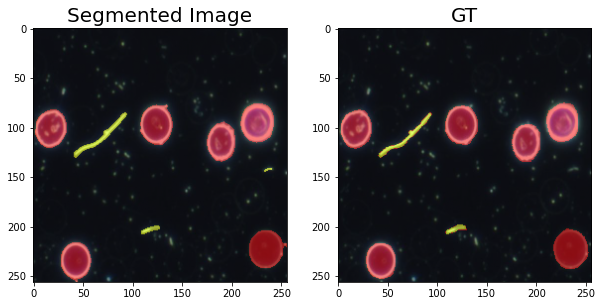

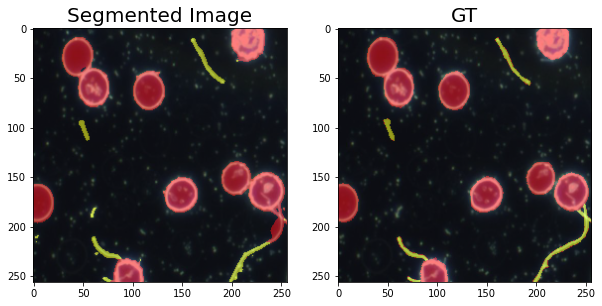

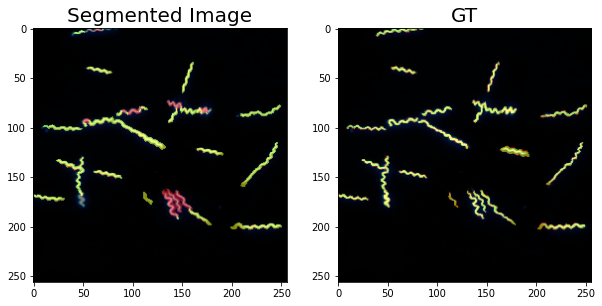

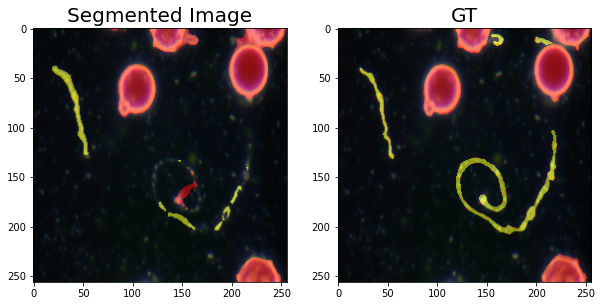

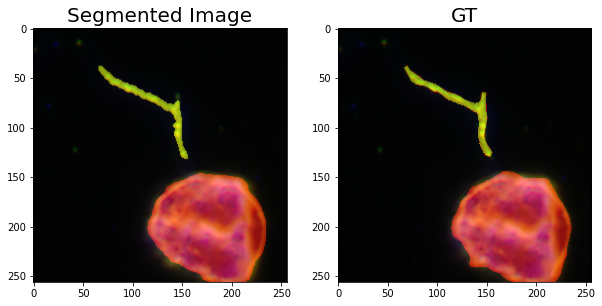

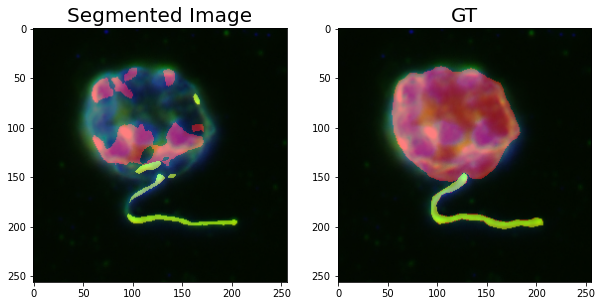

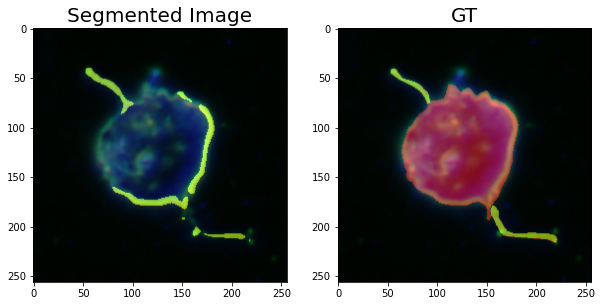

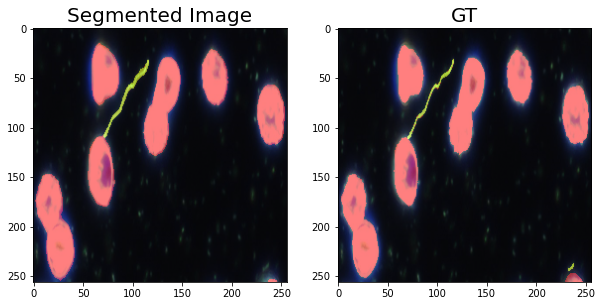

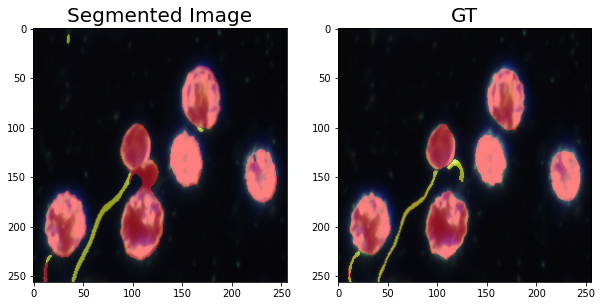

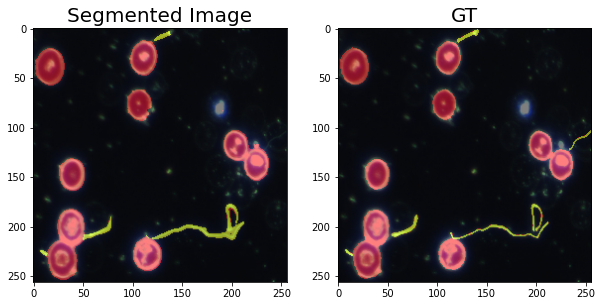

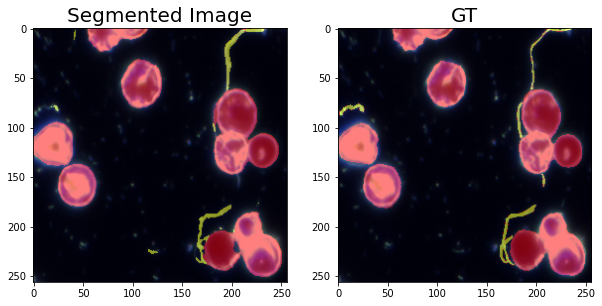

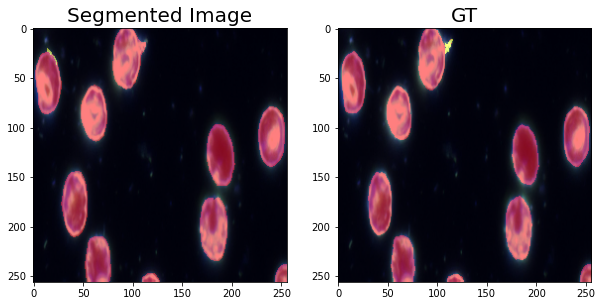

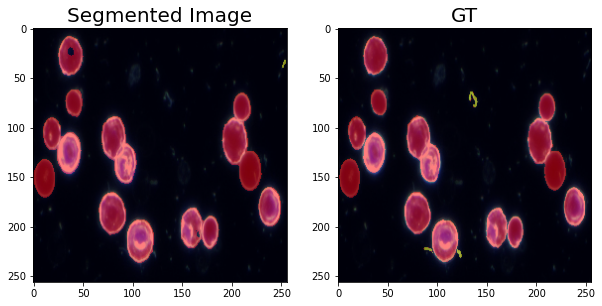

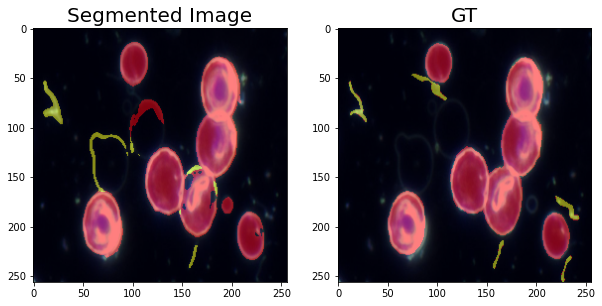

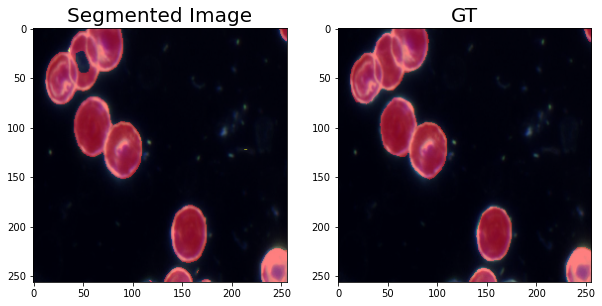

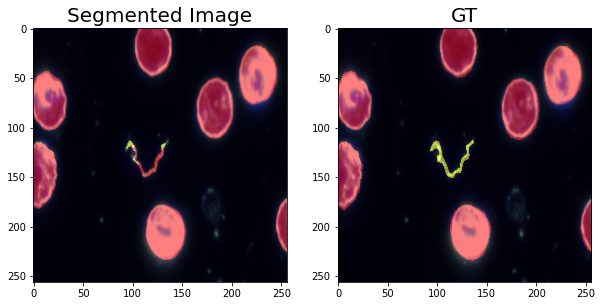

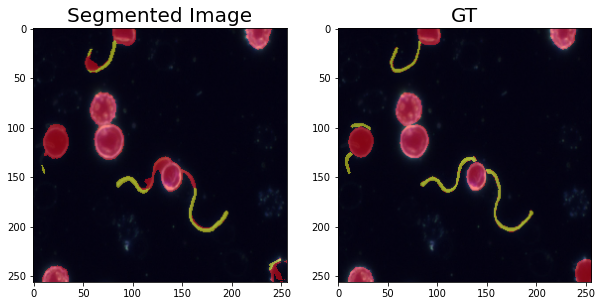

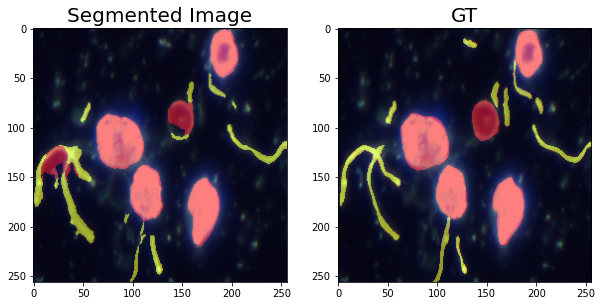

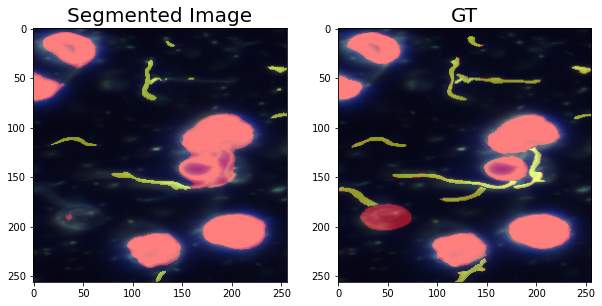

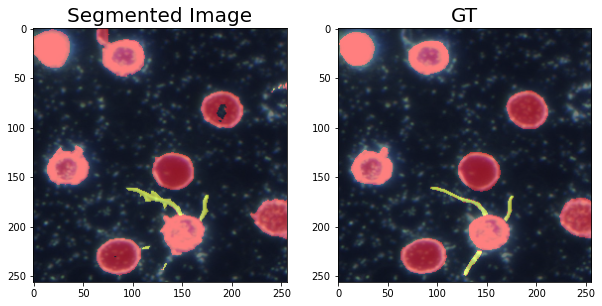

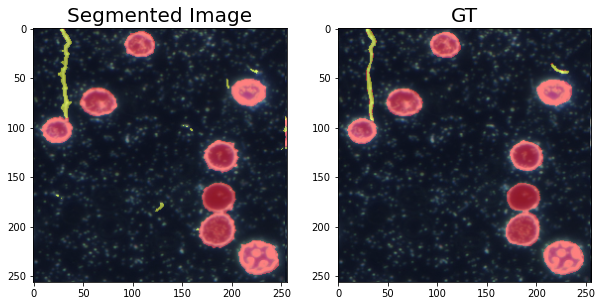

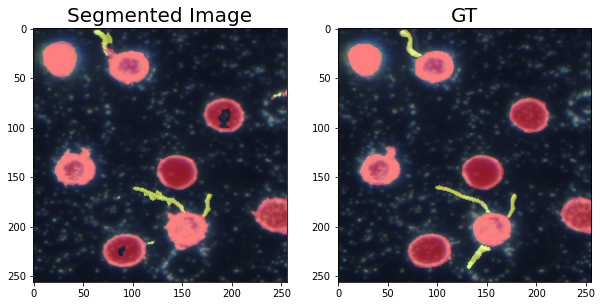

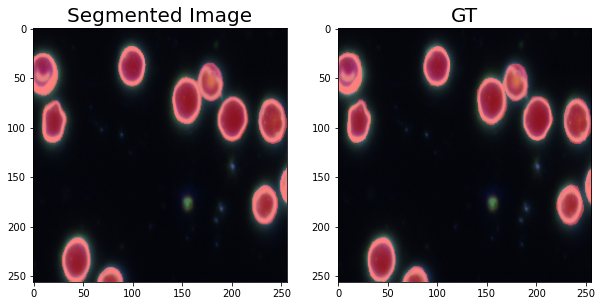

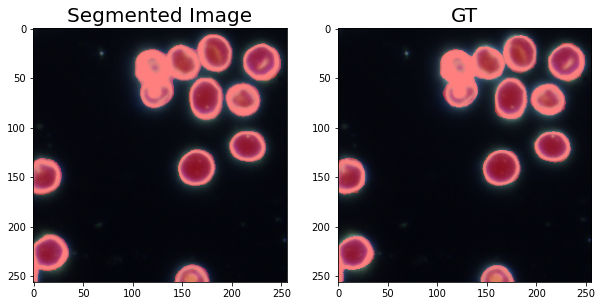

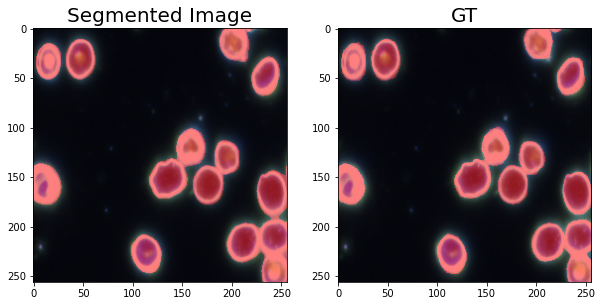

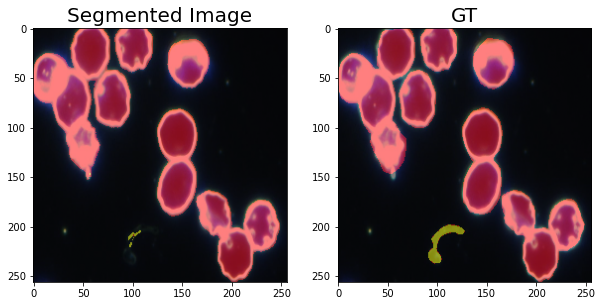

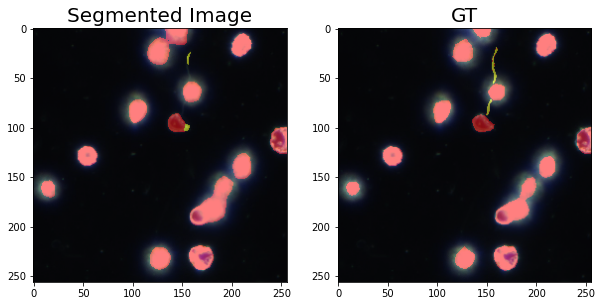

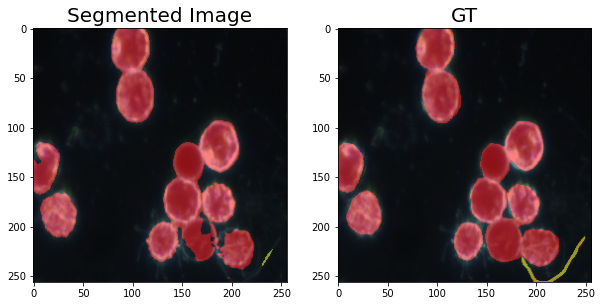

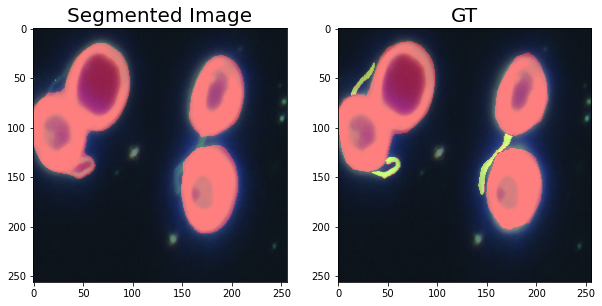

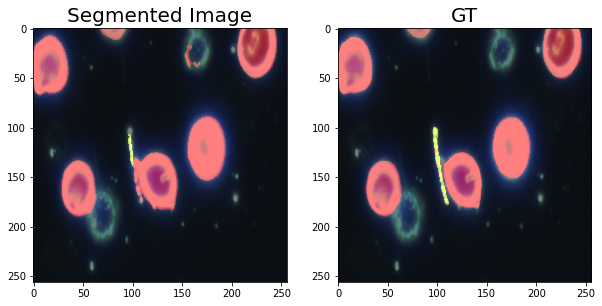

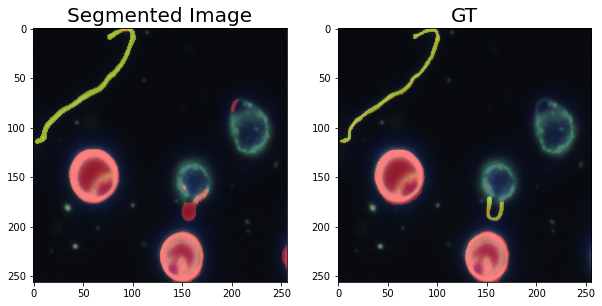

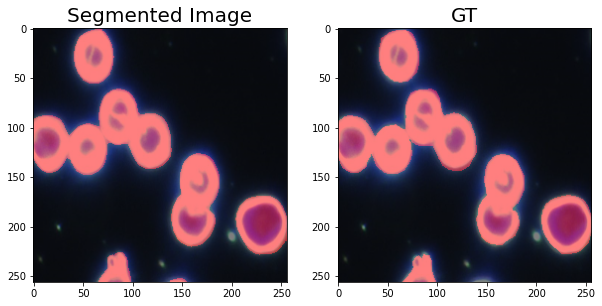

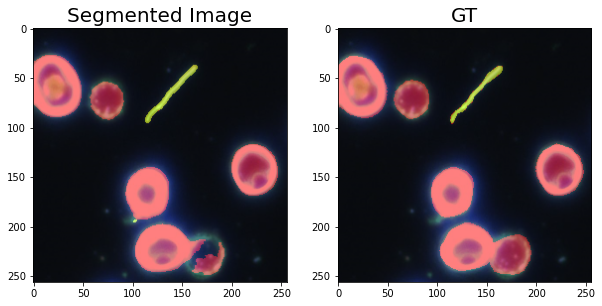

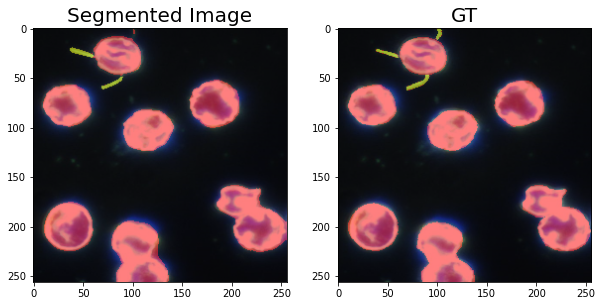

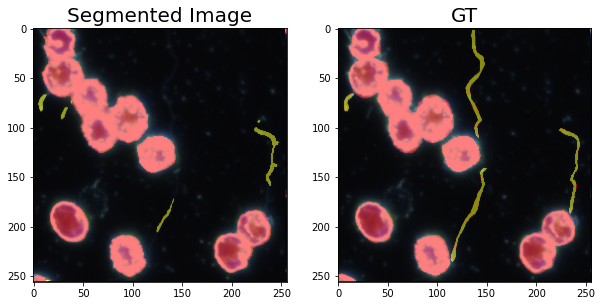

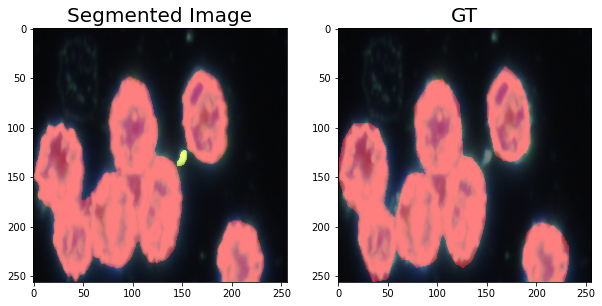

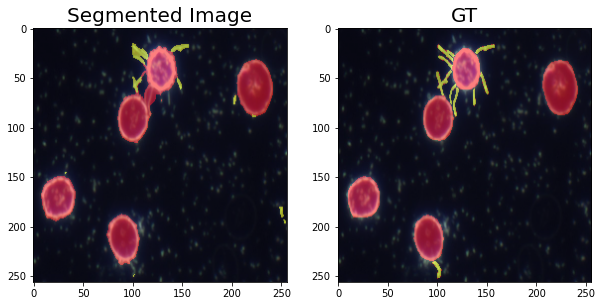

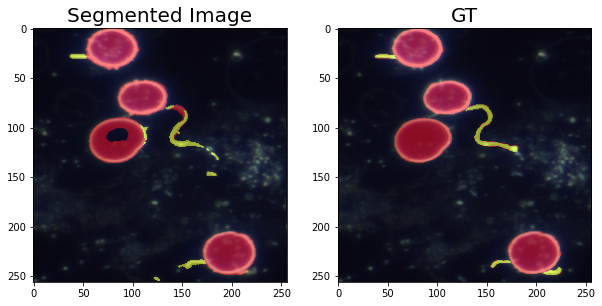

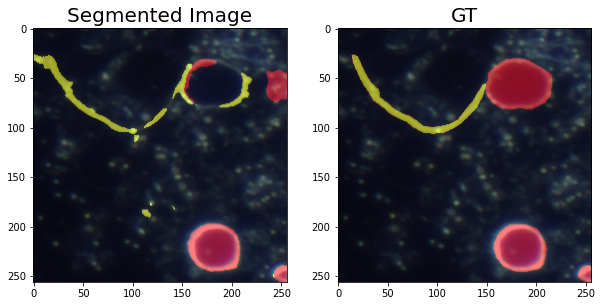

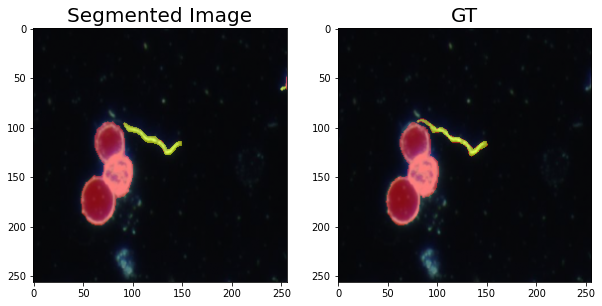

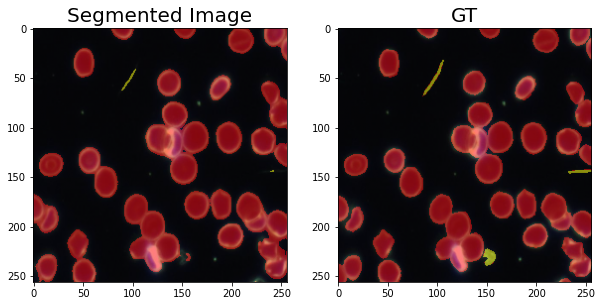

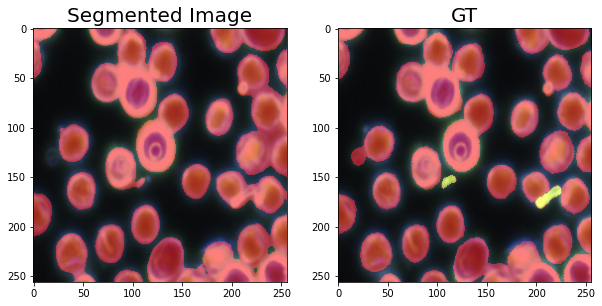

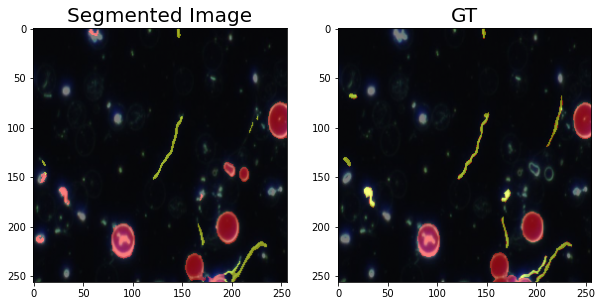

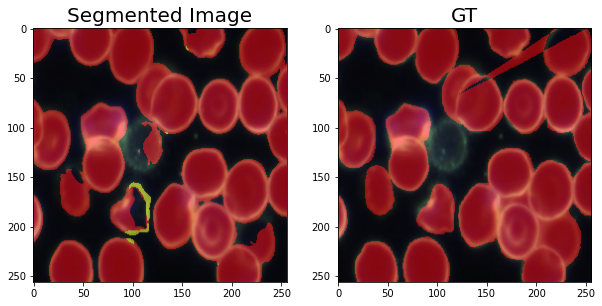

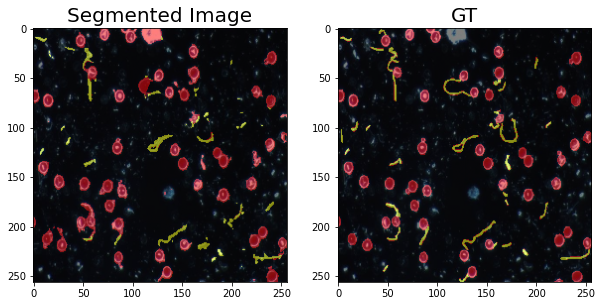

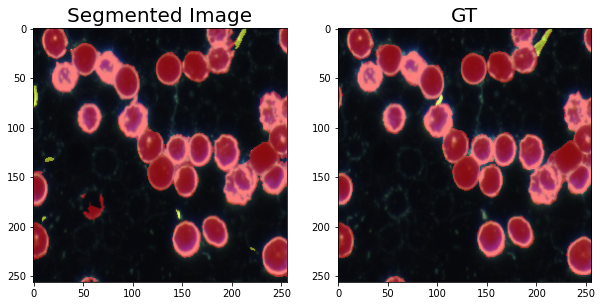

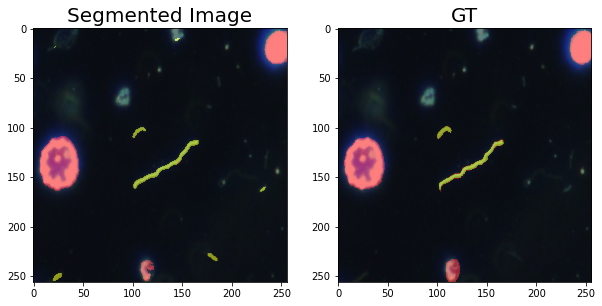

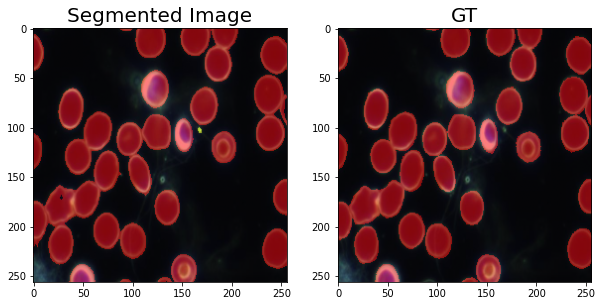

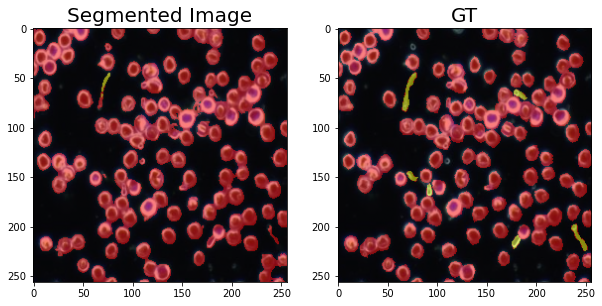

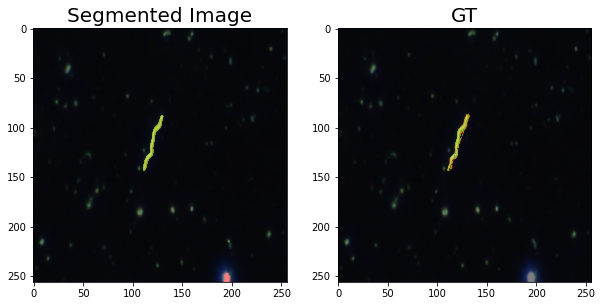

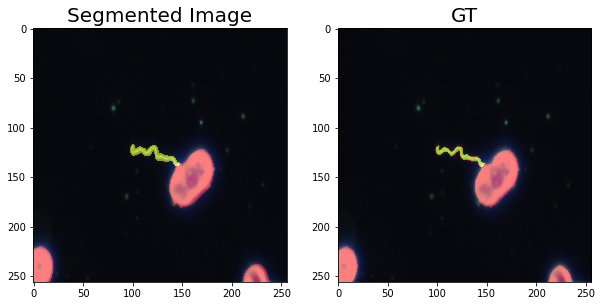

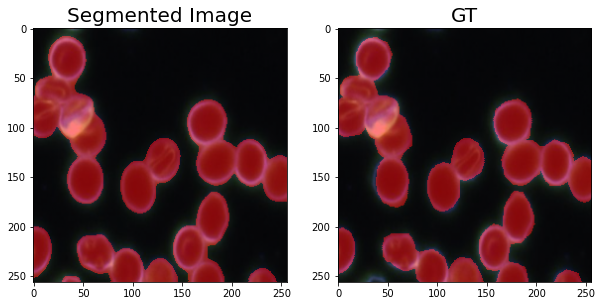

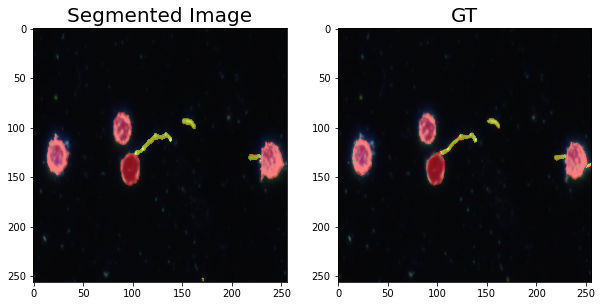

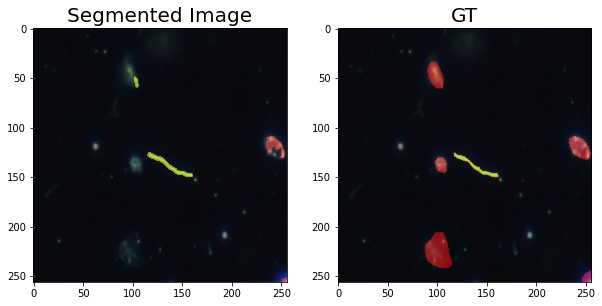

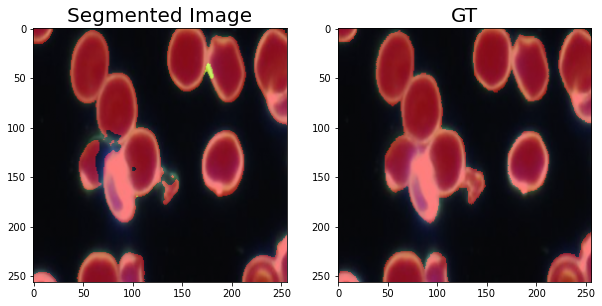

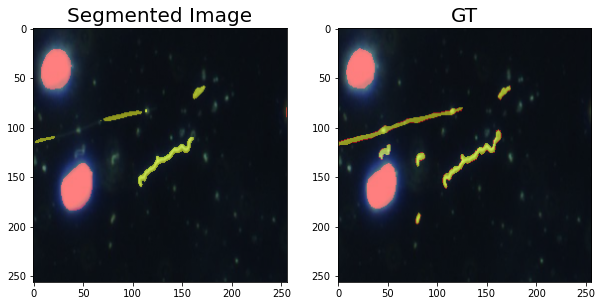

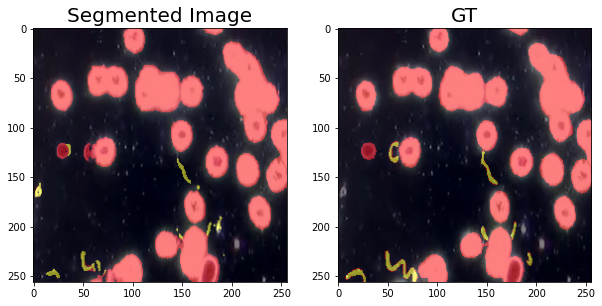

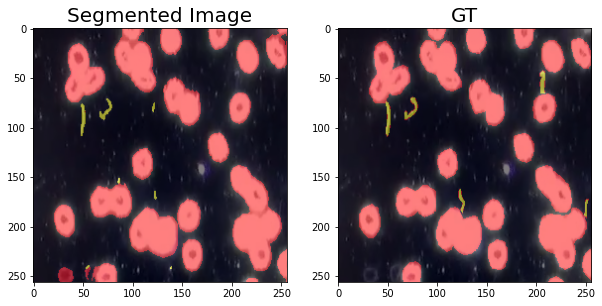

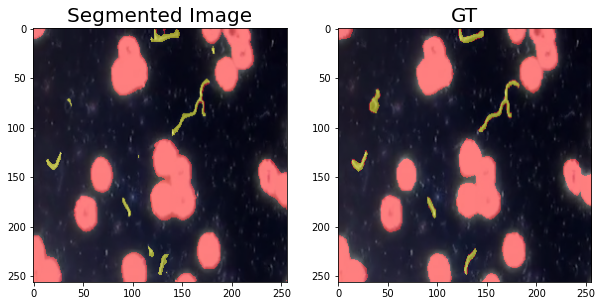

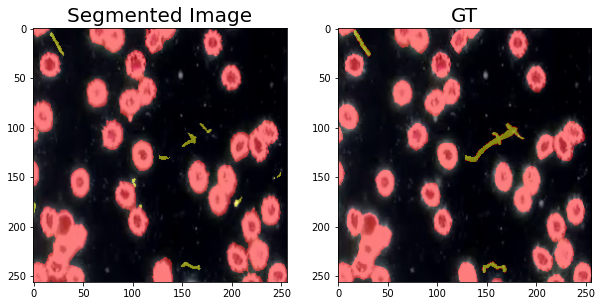

In [34]:
n_correct = 0
n_false = 0
mean_loss = 0.0

metrics_dict = {'mean_iou': 0}
for key, val in converters.get_class_to_id().items():
    metrics_dict[key + '_iou'] = 0
    metrics_dict[key + '_samples'] = 0

for i_batch, sample_batched in enumerate(test_loader):
    output, total_loss = model.eval_net_with_loss(model=model,
                                                  batch=sample_batched,
                                                  class_weights=CLASS_WEIGHTS,
                                                  device=DEVICE)
    mean_loss += total_loss.cpu().detach().numpy()
    label_out = torch.nn.functional.softmax(output, dim=1)
    label_out = label_out.cpu().detach().numpy()
    labels = np.argmax(label_out, axis=1)
    
    images_np = sample_batched['image_original'].cpu().numpy()
    gt_np = sample_batched['gt'].cpu().numpy()

    for sample_i in range(labels.shape[0]):
        current_img = images_np[sample_i, ...]
        current_labels = labels[sample_i, ...]
        current_gt = gt_np[sample_i, ...]
        valid_mask = current_gt != -1

        curr_correct = np.sum(current_gt[valid_mask] == current_labels[valid_mask])
        for key, val in converters.get_class_to_id().items():
            if np.sum(valid_mask & (current_gt == val)) > 1:
                intersection = np.logical_and(valid_mask & (current_gt == val),
                                              valid_mask & (current_labels == val))
                union = np.logical_or(valid_mask & (current_gt == val), valid_mask & (current_labels == val))
                metrics_dict[key + '_iou'] += np.sum(intersection) / np.sum(union)
                metrics_dict[key + '_samples'] += 1

        segmented_img = plot_utils.get_board_image(curr_img=current_img, curr_label=current_labels)
        img_with_gt = plot_utils.get_board_image(curr_img=current_img, curr_label=current_gt)

        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.set_title("Segmented Image", fontsize=20)
        ax1.imshow(segmented_img)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_title("GT", fontsize=20)
        ax2.imshow(img_with_gt)
        plt.show()

        curr_false = np.sum(valid_mask) - curr_correct
        n_correct += curr_correct
        n_false += curr_false

mean_loss /= len(test_loader)
train_acc = n_correct / (n_correct + n_false)

for key, val in converters.get_class_to_id().items():
    metrics_dict[key + '_iou'] /= metrics_dict[key + '_samples']
    metrics_dict['mean_iou'] += metrics_dict[key + '_iou']

metrics_dict['mean_iou'] /= len(converters.get_class_to_id())
metrics_dict['test_acc'] = train_acc
metrics_dict['test_loss'] = mean_loss

In [25]:
metrics_dict

{'background_iou': 0.9655527959973939,
 'background_samples': 72,
 'erythrocytes_iou': 0.7944113887338227,
 'erythrocytes_samples': 72,
 'mean_iou': 0.7281644685863952,
 'spirochaete_iou': 0.42452922102796903,
 'spirochaete_samples': 62,
 'test_acc': 0.9704833560519748,
 'test_loss': 0.3610177308320999}